# Models

---

## Imports

---

In [1]:
from constants import *

import pandas as pd
import numpy as np
import os
from pathlib import Path
import statsmodels.api as sm
import matplotlib.pyplot as plt

import torch # PyTorch
from torch import nn # Modules and layers
from torch.utils.data import Dataset # PyTorch dataset
from torch.utils.data import DataLoader # PyTorch Dataloader

import torch # PyTorch
from torch import nn # Modules and layers
from torch.utils.data import Dataset # PyTorch dataset
from torch.utils.data import DataLoader # PyTorch Dataloader
from torch.nn import BCEWithLogitsLoss

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score

from tabulate import tabulate
from IPython.display import Markdown, display

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression, SelectKBest

In [2]:
processed = Path(os.path.join("../", "data", "processed"))
interim = Path(os.path.join("../", "data", "interim"))

c_stop_res = pd.read_csv(processed/"dev_c_stop_res.csv")
i_stop_res = pd.read_csv(processed/"dev_i_stop_res.csv")
mri_res = pd.read_csv(processed/"dev_mri_res.csv")

c_stop = pd.read_csv(interim/"dev_c_stop_df.csv")
i_stop = pd.read_csv(interim/"dev_i_stop_df.csv")
mri = pd.read_csv(interim/"dev_mri_df.csv")

test_c_stop_res = pd.read_csv(processed/"test_c_stop_res.csv")
test_i_stop_res = pd.read_csv(processed/"test_i_stop_res.csv")
test_mri_res = pd.read_csv(processed/"test_mri_res.csv")

In [84]:
print(len(c_stop_res) / 2)
print(len(test_c_stop_res) / 2)

5626.5
625.5


In [85]:
5626 + 626

6252

In [3]:
NUM_EPOCHS = 50
LEARNING_RATE = 0.001

## Functions

In [4]:
def printmd(string):
    display(Markdown(string))

In [5]:
def get_split(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)
    print("y_train shape:", y_train.shape)
    print("y_test shape:", y_test.shape)
    
    return X_train, X_test, y_train, y_test

In [6]:
def z_normalize(X):
    '''Performs Z-score normalization'''
    scaler = StandardScaler().set_output(transform="pandas")
    X_scaled = scaler.fit_transform(X)
    return X_scaled

In [7]:
def feature_select(X, y, num_features=10):
    '''Selects the top k features.'''
    fs = SelectKBest(score_func=f_regression,k=num_features)

    # Applying feature selection
    fit = fs.fit(X, y)

    features_score = pd.DataFrame(fit.scores_)
    features = pd.DataFrame(X.columns)
    feature_score = pd.concat([features,features_score],axis=1)

    # Assigning column names
    feature_score.columns = ["Input_Features","F_Score"]
    top_features = feature_score.nlargest(num_features,columns="F_Score")
    
    return X[top_features["Input_Features"]]

In [8]:
def get_metrics(target, predictions):
    '''Prints metrics'''
    table = [
        ["Accuracy", "Balanced Accuracy", "f1 Score", "ROC AUC", "Precision"],
        [accuracy_score(target, predictions), balanced_accuracy_score(target, predictions),
        f1_score(target, predictions), roc_auc_score(target, predictions),
        precision_score(target, predictions)]
    ]
    
    print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

In [9]:
def run_standard_models(title, X_train, X_test, y_train, y_test, class_weight=None, feature_importance=False):
    '''Performs Binary Clasisfication Using Scikit-learn Models'''
    names = [
        "SVC",
        "LogisticRegression",
        "RandomForestClassifier",
        "KNeighborsClassifier",
        "MLPClassifier"
    ]

    standard_models = [
        SVC(),
        LogisticRegression(penalty="l2", max_iter=300, class_weight=class_weight),
        RandomForestClassifier(n_estimators=50),
        KNeighborsClassifier(),
        MLPClassifier(hidden_layer_sizes=(2,2), max_iter=1000, random_state=42)
    ]

    trained_models = []
    
    printmd(f"### Running `{title}` experiment")
    printmd("**=====================================================================**")
    
    for name, model in zip(names, standard_models):
        printmd(f"**Trying {name}........**")
        model.fit(X_train, y_train)
        cv_scores = cross_val_score(model, X_train, y_train, cv=5)
        average_cv_score = cv_scores.mean()
        print(f"Average cross-validation score: {average_cv_score*100:.3f}%")

        y_pred = model.predict(X_test)
        get_metrics(y_test, y_pred)

        trained_models.append(model)

    return trained_models
    

## PyTorch Model Pipeline

In [10]:
class ABCDDataset(Dataset):
    '''Creates a PyTorch Tensor Dataset from X and y arrays.'''
    def __init__(self, X, y, y_dtype=torch.int64):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=y_dtype)
        
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
def get_ds(X, y):
    '''Creates a 80/20 split in two different PyTorch Datasets.'''
    X_train, X_test, y_train, y_test = get_split(X, y)
    
    train_ds = ABCDDataset(X_train, y_train)
    test_ds = ABCDDataset(X_test, y_test)
    
    return train_ds, test_ds

def get_dls(X, y):
    '''Creates train and test dataloaders compatible with PyTorch.'''
    train_ds, test_ds = get_ds(X, y)
    train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
    test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)
    
    return train_dl, test_dl

In [11]:
class Model1(nn.Module):
    def __init__(self, input_size, nr_classes=2, save_path="models"):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_size, 2),
            nn.ReLU(),
            nn.Linear(2, 2),
            nn.ReLU(),
            nn.Linear(2, nr_classes),
            nn.Sigmoid()
        )

        self.flatten = nn.Flatten()
        self.softmax = nn.Softmax(dim=1)
            
    def forward(self, x):
        '''Forward pass'''
        x = self.flatten(x)
        logits = self.layers(x)
        return logits

In [12]:
# Code adapted from https://www.geeksforgeeks.org/training-neural-networks-with-validation-using-pytorch/

def train_model(model, loss_f, optimizer, train_dl, valid_dl, num_epochs, bce=False):
    '''Training loop.'''
        
    # Keep track of loss over time
    train_scores = []
    valid_scores = []
    
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    
    for e in range(num_epochs):    
        # Train
        train_loss = 0
        model.train()        

        for data, labels in train_dl:
            
            # Clear the gradients
            optimizer.zero_grad()
            
            # Forward pass
            predictions = model(data)
            
            # Compute loss
            if bce:
                loss = loss_f(predictions, labels.float())
            else:
                loss = loss_f(predictions, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
        
        # Compute validation loss
        valid_loss = 0
        with torch.no_grad():
            model.eval()
            for data, labels in valid_dl:
                predictions = model(data)
                # Compute loss
                if bce:
                    loss = loss_f(predictions, labels.float())
                else:
                    loss = loss_f(predictions, labels)
                valid_loss += loss.item()
            
        avg_train = train_loss / len(train_dl)
        avg_valid = valid_loss / len(valid_dl)
        
        if (e % 10 == 0):
            print(f"Epoch {e + 1}/{num_epochs} - Train loss: {avg_train:.2f} Valid loss: {avg_valid:.2f}")
        
        train_scores.append(avg_train)
        valid_scores.append(avg_valid)
        
        scheduler.step()

    print("Training Completed!")
    
    return train_scores, valid_scores

In [13]:
def plot_learning(train_loss, valid_loss, figname):
    '''Plots train and validation loss performance'''
    fig, ax = plt.subplots(figsize=(5,5), dpi=200)
    ax.plot(train_loss, label="Training Loss")
    ax.plot(valid_loss, label="Validation Loss")
    ax.set_title("Training and Validation Loss")
    ax.set_xlabel("Epoch #")
    ax.set_ylabel("Loss")
    ax.legend()
    plt.tight_layout()
    plt.savefig(os.path.join("../reports/figures/" + figname))
    plt.show()

In [70]:
def evaluate_model(model, dl):
    '''Evaluate model and print metrics.'''
    model.eval()
    targets = []
    predictions = []
    
    for data, labels in dl:
        prediction = model(data)
        targets += list(labels.detach().cpu().numpy())
        predictions += list(prediction.argmax(1).detach().cpu().numpy())
    
    get_metrics(targets, predictions)
    
def evaluate_model_Xy(model, X, y):
    '''Evaluate model and print metrics.'''
    model.eval()
    
    predictions = model(X)
    predictions = list(predictionS.argmax(1).detach().cpu().numpy())
    
    get_metrics(Y, predictions)

In [15]:
def plot_feature_importance(features, figname, n=1, top=5):
    model_names = ["SVC", "Logistic Regression", "RandomForestClassifier", "KNeighborsClassifier", "MLPClassifier"]
    coefficients = trained_models[n].coef_[0]
    
    feature_importance = pd.DataFrame({'Feature': features, 'Importance': np.abs(coefficients)})
    feature_importance = feature_importance.sort_values('Importance', ascending=True)
    
    fig, ax = plt.subplots(dpi=200, figsize=(7,4))
    
    feature_importance.iloc[:top].plot(x='Feature', y='Importance', kind='barh', ax=ax)
    ax.set_title(f"{model_names[n]} Feature Importance")
    plt.tight_layout()
    plt.savefig(os.path.join("../", "reports", "figures", figname))
    plt.show()

In [22]:
def eval_standard_models(test_df, features, models, y_in=[]):
    model_names = ["SVC", "Logistic Regression", "RandomForestClassifier", "KNeighborsClassifier", "MLPClassifier"]

    X = test_df[features]
    if len(y_in) == 0:
        y = test_df["demo_sex_v2"]
    else:
        y = y_in

    for i, model in enumerate(models):
        print(model_names[i])
        
        y_pred = model.predict(X)
        get_metrics(y, y_pred)

def eval_standard_models_Xy(X, y, models):
    model_names = ["SVC", "Logistic Regression", "RandomForestClassifier", "KNeighborsClassifier", "MLPClassifier"]

    for i, model in enumerate(models):
        print(model_names[i])
        
        y_pred = model.predict(X)
        get_metrics(y, y_pred)

---

## No Preprocessing

---

### Baseline

In [9]:
X = c_stop[c_stop["eventname"] == BASELINE][c_stop_go_features]
y = c_stop.iloc[X.index][TARGET]

X_train, X_test, y_train, y_test = get_split(X, y)
run_standard_models("No Preprocessing: Baseline Correct Stop vs. Correct Go", X_train, X_test, y_train, y_test)

X_train shape: (4500, 148)
X_test shape: (1126, 148)
y_train shape: (4500,)
y_test shape: (1126,)


### Running `No Preprocessing: Baseline Correct Stop vs. Correct Go` experiment

**=====================================================================**

**Trying SVC........**

Average cross-validation score: 57.333%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.587034 │            0.576614 │   0.483907 │  0.576614 │    0.582888 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying LogisticRegression........**

Average cross-validation score: 56.622%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.583481 │            0.578065 │   0.525784 │  0.578065 │    0.562771 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying RandomForestClassifier........**

Average cross-validation score: 54.222%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.559503 │            0.549939 │   0.459695 │  0.549939 │    0.539642 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying KNeighborsClassifier........**

Average cross-validation score: 52.178%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.528419 │            0.521294 │   0.448598 │  0.521294 │    0.495413 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying MLPClassifier........**

Average cross-validation score: 55.911%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.575488 │            0.572377 │   0.535922 │  0.572377 │    0.548708 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


In [11]:
X = i_stop[i_stop["eventname"] == BASELINE][i_stop_go_features]
y = i_stop.iloc[X.index][TARGET]

X_train, X_test, y_train, y_test = get_split(X, y)
run_standard_models("No Preprocessing: Baseline Incorrect Stop vs. Correct Go", X_train, X_test, y_train, y_test)

X_train shape: (4500, 148)
X_test shape: (1126, 148)
y_train shape: (4500,)
y_test shape: (1126,)


### Running `No Preprocessing: Baseline Incorrect Stop vs. Correct Go` experiment

**=====================================================================**

**Trying SVC........**

Average cross-validation score: 59.489%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.598579 │            0.590773 │   0.522199 │  0.590773 │    0.589499 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying LogisticRegression........**

Average cross-validation score: 60.956%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.603908 │            0.598176 │   0.545825 │  0.598176 │    0.589011 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying RandomForestClassifier........**

Average cross-validation score: 56.111%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.571936 │            0.563564 │   0.486141 │  0.563564 │    0.554745 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying KNeighborsClassifier........**

Average cross-validation score: 52.533%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.539076 │            0.528688 │   0.426519 │  0.528688 │    0.510582 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying MLPClassifier........**

Average cross-validation score: 59.133%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.586146 │            0.580569 │   0.527383 │  0.580569 │    0.566449 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


---

## Residualization and Z-Normalization

---

### Baseline

In [111]:
X = c_stop_res[c_stop_res["eventname"] == BASELINE][c_stop_go_features_res]
X = z_normalize(X)
y = c_stop_res.iloc[X.index][TARGET]

X_train, X_test, y_train, y_test = get_split(X, y)
trained_models = run_standard_models("Baseline Correct Stop vs. Correct Go", X_train, X_test, y_train, y_test)

X_train shape: (4500, 148)
X_test shape: (1126, 148)
y_train shape: (4500,)
y_test shape: (1126,)


### Running `Baseline Correct Stop vs. Correct Go` experiment

**=====================================================================**

**Trying SVC........**

Average cross-validation score: 57.844%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.608348 │            0.600183 │   0.530351 │  0.600183 │    0.604369 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying LogisticRegression........**

Average cross-validation score: 56.644%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.585258 │            0.580761 │   0.535323 │  0.580761 │    0.562762 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying RandomForestClassifier........**

Average cross-validation score: 53.911%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.568384 │            0.557944 │   0.461197 │  0.557944 │    0.554667 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying KNeighborsClassifier........**

Average cross-validation score: 53.178%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.539964 │            0.530891 │    0.44181 │  0.530891 │    0.511222 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying MLPClassifier........**

Average cross-validation score: 54.356%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.561279 │            0.557767 │   0.517578 │  0.557767 │    0.533199 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


In [112]:
eval_standard_models(test_c_stop_res[test_c_stop_res["eventname"] == BASELINE], c_stop_go_features_res, trained_models)

SVC
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.576677 │            0.562059 │   0.382284 │  0.562059 │    0.621212 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛
Logistic Regression
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.587859 │            0.575318 │   0.431718 │  0.575318 │    0.624204 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛
RandomForestClassifier
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪═════

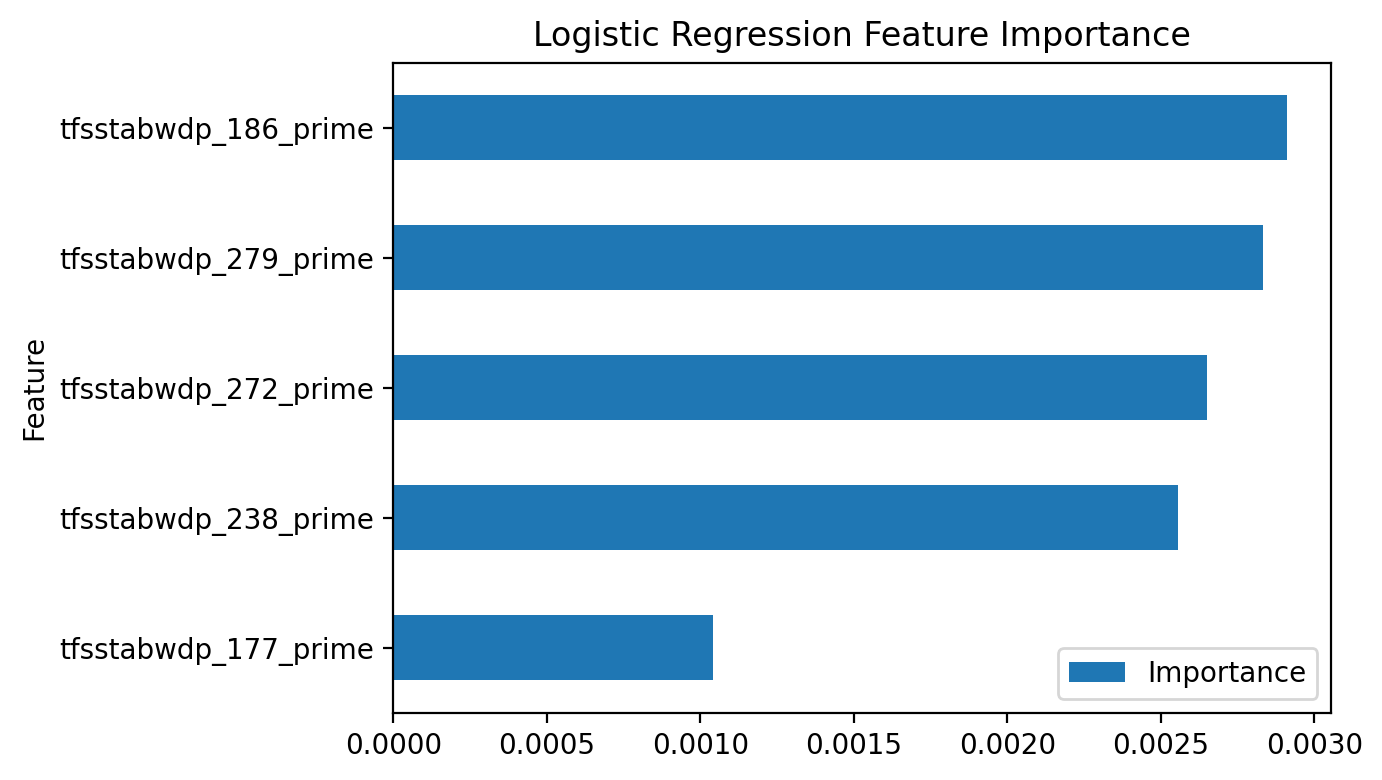

In [113]:
plot_feature_importance(c_stop_go_features_res, "baseline_correct_feature.jpg", n=1)

---

In [20]:
X = c_stop_res[c_stop_res["eventname"] == BASELINE][c_stop_go_features_res]
X = z_normalize(X)
y = c_stop_res.iloc[X.index][TARGET]

X = feature_select(X, y, num_features=80)

X_train, X_test, y_train, y_test = get_split(X, y)
run_standard_models("Baseline Correct Stop vs. Correct Go, Feature Selection", X_train, X_test, y_train, y_test)

X_train shape: (4500, 80)
X_test shape: (1126, 80)
y_train shape: (4500,)
y_test shape: (1126,)


### Running `Baseline Correct Stop vs. Correct Go, Feature Selection` experiment

**=====================================================================**

**Trying SVC........**

Average cross-validation score: 58.733%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│    0.60746 │            0.598094 │   0.518519 │  0.598094 │    0.608696 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying LogisticRegression........**

Average cross-validation score: 56.844%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.594139 │            0.587854 │   0.530319 │  0.587854 │    0.578475 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying RandomForestClassifier........**

Average cross-validation score: 53.844%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.566607 │            0.556959 │   0.467249 │  0.556959 │    0.550129 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying KNeighborsClassifier........**

Average cross-validation score: 53.222%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.564831 │            0.553579 │   0.448198 │  0.553579 │    0.551247 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying MLPClassifier........**

Average cross-validation score: 49.711%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.497336 │            0.515343 │    0.59744 │  0.515343 │    0.477816 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


In [108]:
X = i_stop_res[i_stop_res["eventname"] == BASELINE][i_stop_go_features_res]
X = z_normalize(X)
y = i_stop_res.iloc[X.index][TARGET]

X_train, X_test, y_train, y_test = get_split(X, y)
trained_models = run_standard_models("Baseline Incorrect Stop vs. Correct Go", X_train, X_test, y_train, y_test)

X_train shape: (4500, 148)
X_test shape: (1126, 148)
y_train shape: (4500,)
y_test shape: (1126,)


### Running `Baseline Incorrect Stop vs. Correct Go` experiment

**=====================================================================**

**Trying SVC........**

Average cross-validation score: 60.889%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.611901 │            0.604548 │   0.541448 │  0.604548 │    0.605634 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying LogisticRegression........**

Average cross-validation score: 60.556%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.598579 │            0.592825 │   0.539715 │  0.592825 │    0.582418 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying RandomForestClassifier........**

Average cross-validation score: 56.378%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.561279 │            0.553776 │    0.48218 │  0.553776 │    0.538642 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying KNeighborsClassifier........**

Average cross-validation score: 53.867%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.547957 │            0.537035 │   0.431285 │  0.537035 │    0.524457 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying MLPClassifier........**

Average cross-validation score: 58.089%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.611901 │            0.597934 │   0.477897 │  0.597934 │    0.645161 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


In [109]:
eval_standard_models(test_i_stop_res[test_i_stop_res["eventname"] == BASELINE], i_stop_go_features_res, trained_models)

SVC
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.549521 │            0.528036 │   0.184971 │  0.528036 │    0.653061 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛
Logistic Regression
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.579872 │            0.574105 │   0.510242 │  0.574105 │    0.570833 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛
RandomForestClassifier
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪═════

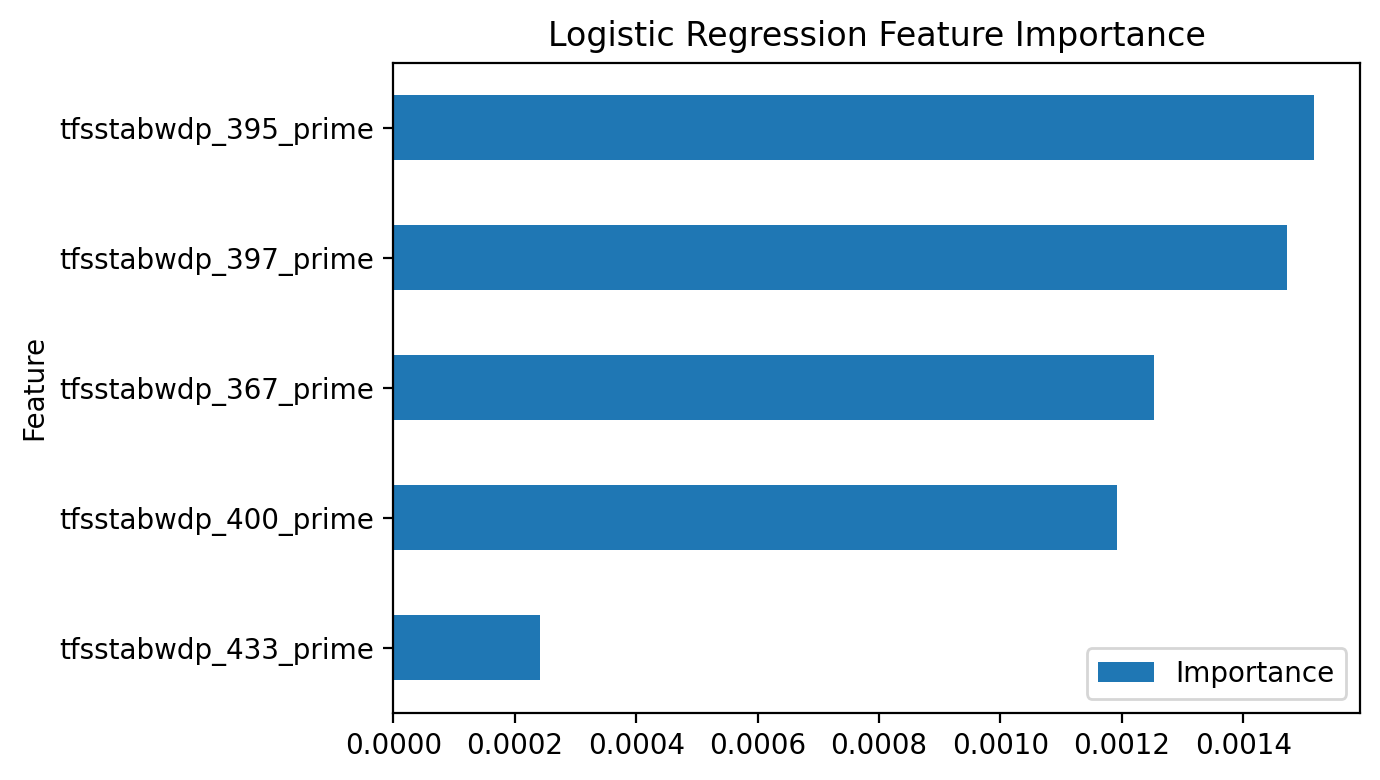

In [110]:
plot_feature_importance(i_stop_go_features_res, "baseline_incorrect_feature.jpg", n=1)

In [57]:
X = i_stop_res[i_stop_res["eventname"] == BASELINE][i_stop_go_features_res]
X = z_normalize(X)
y = i_stop_res.iloc[X.index][TARGET]

X = feature_select(X, y, num_features=80)

X_train, X_test, y_train, y_test = get_split(X, y)
trained_models = run_standard_models("Baseline Incorrect Stop vs. Correct Go, Feature Selection", X_train, X_test, y_train, y_test)

X_train shape: (4500, 80)
X_test shape: (1126, 80)
y_train shape: (4500,)
y_test shape: (1126,)


### Running `Baseline Incorrect Stop vs. Correct Go, Feature Selection` experiment

**=====================================================================**

**Trying SVC........**

Average cross-validation score: 60.400%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.618117 │            0.611189 │   0.552083 │  0.611189 │    0.612009 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying LogisticRegression........**

Average cross-validation score: 61.356%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.601243 │            0.595786 │   0.545086 │  0.595786 │    0.584783 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying RandomForestClassifier........**

Average cross-validation score: 57.600%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.577265 │            0.572222 │   0.522088 │  0.572222 │    0.554371 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying KNeighborsClassifier........**

Average cross-validation score: 54.867%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.525755 │            0.515597 │   0.413187 │  0.515597 │    0.490862 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying MLPClassifier........**

Average cross-validation score: 54.667%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.541741 │            0.553886 │   0.603077 │  0.553886 │    0.507115 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


### Followup

In [23]:
X = c_stop_res[c_stop_res["eventname"] == FOLLOWUP][c_stop_go_features_res]
X = z_normalize(X)
y = c_stop_res.iloc[X.index][TARGET]

X_train, X_test, y_train, y_test = get_split(X, y)
run_standard_models("Followup Correct Stop vs. Correct Go", X_train, X_test, y_train, y_test)

X_train shape: (4501, 148)
X_test shape: (1126, 148)
y_train shape: (4501,)
y_test shape: (1126,)


### Running `Followup Correct Stop vs. Correct Go` experiment

**=====================================================================**

**Trying SVC........**

Average cross-validation score: 60.964%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.594139 │             0.59232 │   0.520462 │   0.59232 │    0.624685 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying LogisticRegression........**

Average cross-validation score: 59.587%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.585258 │            0.584078 │   0.538081 │  0.584078 │    0.597802 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying RandomForestClassifier........**

Average cross-validation score: 56.409%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.568384 │             0.56655 │   0.489496 │   0.56655 │    0.588384 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying KNeighborsClassifier........**

Average cross-validation score: 53.988%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.539964 │            0.539209 │   0.506667 │  0.539209 │    0.538462 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying MLPClassifier........**

Average cross-validation score: 57.743%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.563055 │            0.559586 │    0.38806 │  0.559586 │    0.629032 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


In [24]:
X = c_stop_res[c_stop_res["eventname"] == FOLLOWUP][c_stop_go_features_res]
X = z_normalize(X)
y = c_stop_res.iloc[X.index][TARGET]

X = feature_select(X, y, num_features=80)

X_train, X_test, y_train, y_test = get_split(X, y)
run_standard_models("Followup Correct Stop vs. Correct Go, Feature Selection", X_train, X_test, y_train, y_test)

X_train shape: (4501, 80)
X_test shape: (1126, 80)
y_train shape: (4501,)
y_test shape: (1126,)


### Running `Followup Correct Stop vs. Correct Go, Feature Selection` experiment

**=====================================================================**

**Trying SVC........**

Average cross-validation score: 58.120%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.578153 │            0.576111 │    0.49089 │  0.576111 │    0.607427 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying LogisticRegression........**

Average cross-validation score: 57.876%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.568384 │             0.56697 │   0.509091 │   0.56697 │    0.580645 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying RandomForestClassifier........**

Average cross-validation score: 54.877%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│    0.55151 │            0.549707 │   0.471204 │  0.549707 │     0.56391 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying KNeighborsClassifier........**

Average cross-validation score: 53.322%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.527531 │            0.526972 │   0.501873 │  0.526972 │    0.523438 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying MLPClassifier........**

Average cross-validation score: 52.278%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│    0.51421 │            0.508911 │   0.143975 │  0.508911 │    0.554217 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


In [114]:
X = i_stop_res[i_stop_res["eventname"] == FOLLOWUP][i_stop_go_features_res]
X = z_normalize(X)
y = i_stop_res.iloc[X.index][TARGET]

X_train, X_test, y_train, y_test = get_split(X, y)
trained_models = run_standard_models("Followup Incorrect Stop vs. Correct Go", X_train, X_test, y_train, y_test)

X_train shape: (4501, 148)
X_test shape: (1126, 148)
y_train shape: (4501,)
y_test shape: (1126,)


### Running `Followup Incorrect Stop vs. Correct Go` experiment

**=====================================================================**

**Trying SVC........**

Average cross-validation score: 62.675%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│    0.62611 │            0.624606 │   0.570846 │  0.624606 │    0.658824 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying LogisticRegression........**

Average cross-validation score: 62.542%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.635879 │            0.634741 │   0.595661 │  0.634741 │    0.659389 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying RandomForestClassifier........**

Average cross-validation score: 58.943%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.592362 │            0.590654 │   0.523364 │  0.590654 │    0.619165 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying KNeighborsClassifier........**

Average cross-validation score: 55.054%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.540853 │            0.538584 │   0.433735 │  0.538584 │    0.554622 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying MLPClassifier........**

Average cross-validation score: 59.765%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.598579 │            0.595557 │   0.464455 │  0.595557 │    0.680556 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


In [115]:
eval_standard_models(test_i_stop_res[test_i_stop_res["eventname"] == FOLLOWUP], i_stop_go_features_res, trained_models)

SVC
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│     0.5984 │            0.581774 │   0.386308 │  0.581774 │    0.699115 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛
Logistic Regression
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│     0.6112 │            0.601557 │   0.505092 │  0.601557 │    0.635897 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛
RandomForestClassifier
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪═════

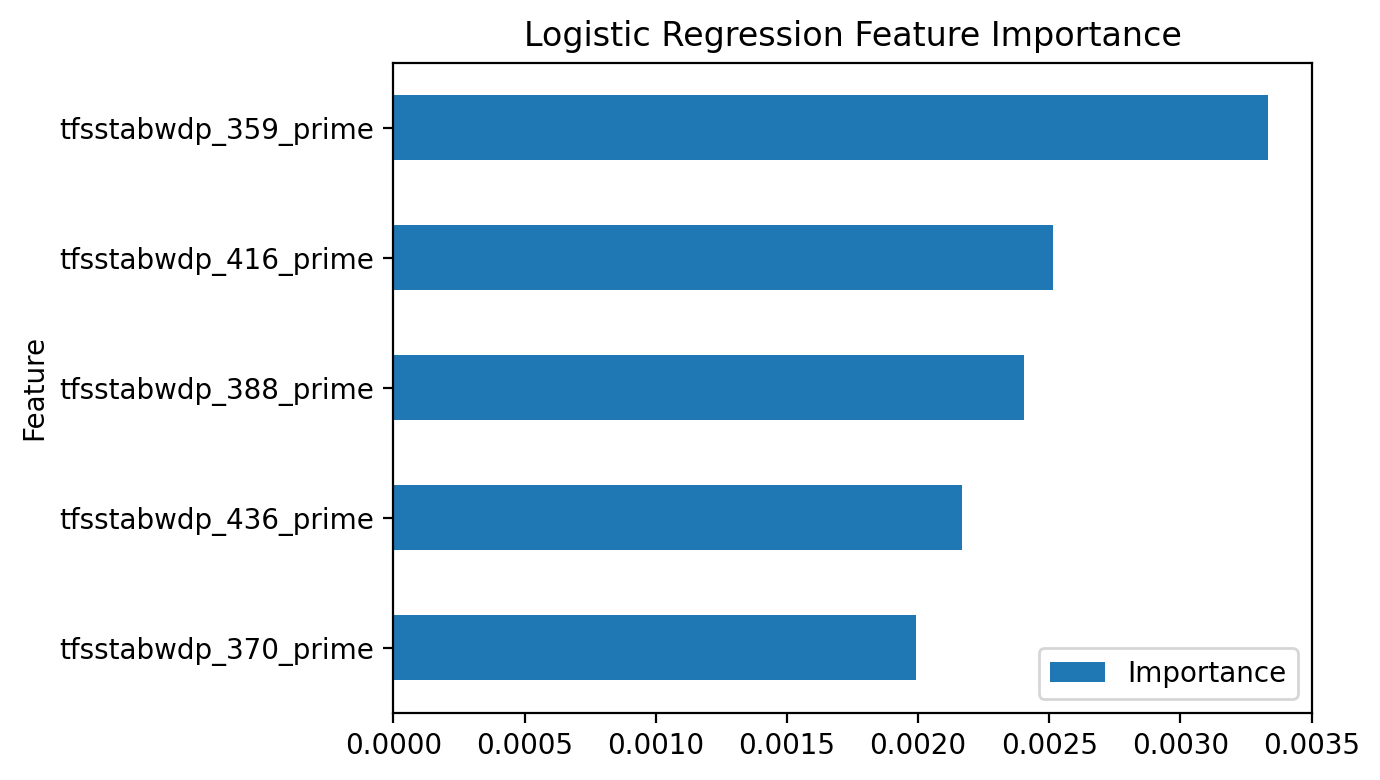

In [116]:
plot_feature_importance(i_stop_go_features_res, "followup_incorrect_feature.jpg", n=1)

In [49]:
X = i_stop_res[c_stop_res["eventname"] == FOLLOWUP][i_stop_go_features_res]
X = z_normalize(X)
y = i_stop_res.iloc[X.index][TARGET]

X = feature_select(X, y, num_features=80)

X_train, X_test, y_train, y_test = get_split(X, y)
trained_models = run_standard_models("Followup Incorrect Stop vs. Correct Go, Feature Selection", X_train, X_test, y_train, y_test)

X_train shape: (4501, 80)
X_test shape: (1126, 80)
y_train shape: (4501,)
y_test shape: (1126,)


### Running `Followup Incorrect Stop vs. Correct Go, Feature Selection` experiment

**=====================================================================**

**Trying SVC........**

Average cross-validation score: 61.720%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.619005 │            0.617676 │   0.569709 │  0.617676 │    0.643991 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying LogisticRegression........**

Average cross-validation score: 60.365%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.619005 │            0.617941 │   0.579824 │  0.617941 │    0.636559 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying RandomForestClassifier........**

Average cross-validation score: 58.232%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.583481 │            0.581595 │   0.504752 │  0.581595 │    0.611253 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying KNeighborsClassifier........**

Average cross-validation score: 55.343%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.539964 │            0.538082 │   0.453586 │  0.538082 │    0.548469 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying MLPClassifier........**

Average cross-validation score: 58.054%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│    0.60302 │             0.60372 │   0.621507 │   0.60372 │      0.5872 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


### Followup - Baseline

In [27]:
X_baseline = c_stop_res[c_stop_res["eventname"] == BASELINE][c_stop_go_features_res]
X_followup = c_stop_res[c_stop_res["eventname"] == FOLLOWUP][c_stop_go_features_res].reset_index(drop=True)
X_followup.drop(X_followup.tail(1).index,inplace=True)

X = X_followup.reset_index(drop=True) - X_baseline.reset_index(drop=True)
y = c_stop_res.iloc[X_baseline.index][TARGET]

X_train, X_test, y_train, y_test = get_split(X, y)
run_standard_models("Followup - Baseline, Correct Stop vs. Correct Go", X_train, X_test, y_train, y_test)

X_train shape: (4500, 148)
X_test shape: (1126, 148)
y_train shape: (4500,)
y_test shape: (1126,)


### Running `Followup - Baseline, Correct Stop vs. Correct Go` experiment

**=====================================================================**

**Trying SVC........**

Average cross-validation score: 52.911%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│     0.5373 │            0.524167 │   0.392065 │  0.524167 │    0.509091 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying LogisticRegression........**

Average cross-validation score: 51.222%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.529307 │             0.51962 │   0.422658 │   0.51962 │    0.496164 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying RandomForestClassifier........**

Average cross-validation score: 51.978%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.507993 │             0.49856 │   0.400433 │   0.49856 │    0.465995 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying KNeighborsClassifier........**

Average cross-validation score: 51.956%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.540853 │            0.535945 │   0.483516 │  0.535945 │    0.510549 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying MLPClassifier........**

Average cross-validation score: 50.667%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│    0.50444 │            0.505371 │   0.495479 │  0.505371 │     0.47323 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


In [28]:
X_baseline = i_stop_res[c_stop_res["eventname"] == BASELINE][i_stop_go_features_res]
X_followup = i_stop_res[c_stop_res["eventname"] == FOLLOWUP][i_stop_go_features_res].reset_index(drop=True)
X_followup.drop(X_followup.tail(1).index,inplace=True)

X = X_followup.reset_index(drop=True) - X_baseline.reset_index(drop=True)
y = i_stop_res.iloc[X_baseline.index][TARGET]

X_train, X_test, y_train, y_test = get_split(X, y)
run_standard_models("Followup - Baseline, Incorrect Stop vs. Correct Go", X_train, X_test, y_train, y_test)

X_train shape: (4500, 148)
X_test shape: (1126, 148)
y_train shape: (4500,)
y_test shape: (1126,)


### Running `Followup - Baseline, Incorrect Stop vs. Correct Go` experiment

**=====================================================================**

**Trying SVC........**

Average cross-validation score: 53.600%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│    0.53286 │            0.516915 │    0.34901 │  0.516915 │    0.501779 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying LogisticRegression........**

Average cross-validation score: 51.756%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.528419 │            0.517417 │   0.406704 │  0.517417 │    0.494565 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying RandomForestClassifier........**

Average cross-validation score: 52.244%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.535524 │            0.524095 │   0.410372 │  0.524095 │    0.505556 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying KNeighborsClassifier........**

Average cross-validation score: 51.556%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.530195 │             0.52456 │   0.465116 │   0.52456 │    0.497835 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying MLPClassifier........**

Average cross-validation score: 50.044%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.511545 │             0.51011 │   0.483083 │   0.51011 │    0.478585 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


In [29]:
title = "Baseline + (Followup - Baseline), Correct Stop vs. Correct Go"

X_baseline = c_stop_res[c_stop_res["eventname"] == BASELINE][c_stop_go_features_res]
X_followup = c_stop_res[c_stop_res["eventname"] == FOLLOWUP][c_stop_go_features_res].reset_index(drop=True)
X_followup.drop(X_followup.tail(1).index,inplace=True)

X_diff = X_followup.reset_index(drop=True) - X_baseline.reset_index(drop=True)
y = c_stop_res.iloc[X_baseline.index][TARGET]

X = pd.concat([X_baseline.reset_index(drop=True), X_diff], keys=c_stop_go_features_res, axis=1)

X_train, X_test, y_train, y_test = get_split(X, y)
run_standard_models(title, X_train, X_test, y_train, y_test)

X_train shape: (4500, 296)
X_test shape: (1126, 296)
y_train shape: (4500,)
y_test shape: (1126,)


### Running `Baseline + (Followup - Baseline), Correct Stop vs. Correct Go` experiment

**=====================================================================**

**Trying SVC........**

Average cross-validation score: 56.622%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.565719 │            0.554756 │   0.452408 │  0.554756 │    0.551913 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying LogisticRegression........**

Average cross-validation score: 59.400%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│    0.58881 │             0.58467 │   0.542038 │   0.58467 │    0.566116 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying RandomForestClassifier........**

Average cross-validation score: 55.133%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.541741 │            0.530736 │   0.422819 │  0.530736 │    0.514986 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying KNeighborsClassifier........**

Average cross-validation score: 51.333%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.521314 │            0.515643 │   0.455005 │  0.515643 │    0.487013 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying MLPClassifier........**

Average cross-validation score: 50.600%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.509769 │            0.533302 │    0.63249 │  0.533302 │    0.487179 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


In [30]:
title = "Baseline + (Followup - Baseline), Incorrect Stop vs. Correct Go"

X_baseline = i_stop_res[c_stop_res["eventname"] == BASELINE][i_stop_go_features_res]
X_followup = i_stop_res[c_stop_res["eventname"] == FOLLOWUP][i_stop_go_features_res].reset_index(drop=True)
X_followup.drop(X_followup.tail(1).index,inplace=True)

X_diff = X_followup.reset_index(drop=True) - X_baseline.reset_index(drop=True)
y = i_stop_res.iloc[X_baseline.index][TARGET]

X = pd.concat([X_baseline.reset_index(drop=True), X_diff], keys=i_stop_go_features_res, axis=1)

X_train, X_test, y_train, y_test = get_split(X, y)
run_standard_models(title, X_train, X_test, y_train, y_test)

X_train shape: (4500, 296)
X_test shape: (1126, 296)
y_train shape: (4500,)
y_test shape: (1126,)


### Running `Baseline + (Followup - Baseline), Incorrect Stop vs. Correct Go` experiment

**=====================================================================**

**Trying SVC........**

Average cross-validation score: 59.889%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.604796 │            0.597984 │   0.537902 │  0.597984 │    0.594037 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying LogisticRegression........**

Average cross-validation score: 62.622%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.627886 │            0.623907 │   0.585559 │  0.623907 │     0.61157 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying RandomForestClassifier........**

Average cross-validation score: 56.067%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.559503 │            0.552334 │   0.483333 │  0.552334 │    0.535797 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying KNeighborsClassifier........**

Average cross-validation score: 51.022%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.526643 │            0.519739 │   0.448811 │  0.519739 │    0.493182 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying MLPClassifier........**

Average cross-validation score: 49.600%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.488455 │            0.512926 │   0.621053 │  0.512926 │    0.475327 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


In [31]:
title = "Baseline + Followup + (Followup - Baseline), Correct Stop vs. Correct Go"

X_baseline = c_stop_res[c_stop_res["eventname"] == BASELINE][c_stop_go_features_res]
X_followup = c_stop_res[c_stop_res["eventname"] == FOLLOWUP][c_stop_go_features_res].reset_index(drop=True)
X_followup.drop(X_followup.tail(1).index,inplace=True)

X_diff = X_followup.reset_index(drop=True) - X_baseline.reset_index(drop=True)
y = c_stop_res.iloc[X_baseline.index][TARGET]

X = pd.concat([X_baseline.reset_index(drop=True), X_followup.reset_index(drop=True), X_diff], keys=c_stop_go_features_res, axis=1)

X_train, X_test, y_train, y_test = get_split(X, y)
run_standard_models(title, X_train, X_test, y_train, y_test)

X_train shape: (4500, 444)
X_test shape: (1126, 444)
y_train shape: (4500,)
y_test shape: (1126,)


### Running `Baseline + Followup + (Followup - Baseline), Correct Stop vs. Correct Go` experiment

**=====================================================================**

**Trying SVC........**

Average cross-validation score: 57.733%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.576377 │            0.565115 │   0.462232 │  0.565115 │    0.569444 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying LogisticRegression........**

Average cross-validation score: 59.844%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.594139 │            0.589792 │   0.546177 │  0.589792 │    0.572917 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying RandomForestClassifier........**

Average cross-validation score: 54.022%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│    0.57016 │            0.559386 │   0.459821 │  0.559386 │    0.558266 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying KNeighborsClassifier........**

Average cross-validation score: 51.244%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.547957 │            0.542965 │    0.49049 │  0.542965 │    0.519068 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying MLPClassifier........**

Average cross-validation score: 60.578%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│    0.58881 │            0.583529 │   0.532795 │  0.583529 │    0.568966 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


In [19]:
title = "Baseline + Followup + (Followup - Baseline), Incorrect Stop vs. Correct Go"

X_baseline = i_stop_res[i_stop_res["eventname"] == BASELINE][i_stop_go_features_res]
X_followup = i_stop_res[i_stop_res["eventname"] == FOLLOWUP][i_stop_go_features_res].reset_index(drop=True)
X_followup.drop(X_followup.tail(1).index,inplace=True)

X_diff = X_followup.reset_index(drop=True) - X_baseline.reset_index(drop=True)
y = i_stop_res.iloc[X_baseline.index][TARGET]

X = pd.concat([X_baseline.reset_index(drop=True), X_followup.reset_index(drop=True), X_diff], keys=i_stop_go_features_res, axis=1)

X_train, X_test, y_train, y_test = get_split(X, y)
trained_models = run_standard_models(title, X_train, X_test, y_train, y_test)

X_train shape: (4500, 444)
X_test shape: (1126, 444)
y_train shape: (4500,)
y_test shape: (1126,)


### Running `Baseline + Followup + (Followup - Baseline), Incorrect Stop vs. Correct Go` experiment

**=====================================================================**

**Trying SVC........**

Average cross-validation score: 60.356%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.612789 │            0.606295 │   0.549587 │  0.606295 │    0.603175 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying LogisticRegression........**

Average cross-validation score: 62.978%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.623446 │            0.619505 │   0.581028 │  0.619505 │    0.606186 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying RandomForestClassifier........**

Average cross-validation score: 57.267%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.591474 │            0.582955 │   0.507495 │  0.582955 │     0.58231 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying KNeighborsClassifier........**

Average cross-validation score: 52.000%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.526643 │              0.5178 │   0.428725 │    0.5178 │    0.492611 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying MLPClassifier........**

Average cross-validation score: 61.578%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│    0.62611 │            0.620413 │   0.570846 │  0.620413 │     0.61674 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


In [43]:
title = "Baseline + Followup + (Followup - Baseline), Incorrect Stop vs. Correct Go"

X_baseline = test_i_stop_res[test_i_stop_res["eventname"] == BASELINE][i_stop_go_features_res]
X_followup = test_i_stop_res[test_i_stop_res["eventname"] == FOLLOWUP][i_stop_go_features_res].reset_index(drop=True)
X_followup.drop(X_followup.tail(1).index,inplace=True)

X_diff = X_followup.reset_index(drop=True) - X_baseline.reset_index(drop=True)

X = pd.concat([X_baseline.reset_index(drop=True), X_followup.reset_index(drop=True), X_diff], keys=i_stop_go_features_res, axis=1)
X["demo_sex_v2"] = test_i_stop_res[test_i_stop_res["eventname"] == BASELINE].reset_index(drop=True)["demo_sex_v2"]
X = X.dropna()

y = X["demo_sex_v2"]
X = X.drop("demo_sex_v2", axis=1)

eval_standard_models_Xy(X, y, trained_models)

SVC
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.538462 │            0.530957 │   0.446154 │  0.530957 │    0.515556 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛
Logistic Regression
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.548077 │            0.543754 │   0.492806 │  0.543754 │    0.524904 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛
RandomForestClassifier
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪═════

In [22]:
title = "Baseline + Followup + (Followup - Baseline), Feature Selection, Incorrect Stop vs. Correct Go"

X_baseline = i_stop_res[i_stop_res["eventname"] == BASELINE][i_stop_go_features_res]
X_followup = i_stop_res[i_stop_res["eventname"] == FOLLOWUP][i_stop_go_features_res].reset_index(drop=True)
X_followup.drop(X_followup.tail(1).index,inplace=True)

X_diff = X_followup.reset_index(drop=True) - X_baseline.reset_index(drop=True)
y = i_stop_res.iloc[X_baseline.index][TARGET]

X = pd.concat([X_baseline.reset_index(drop=True), X_followup.reset_index(drop=True), X_diff], keys=i_stop_go_features_res, axis=1)
X = feature_select(X, y, num_features=80)
    
X_train, X_test, y_train, y_test = get_split(X, y)
trained_models = run_standard_models(title, X_train, X_test, y_train, y_test, feature_importance=True)

X_train shape: (4500, 80)
X_test shape: (1126, 80)
y_train shape: (4500,)
y_test shape: (1126,)


### Running `Baseline + Followup + (Followup - Baseline), Feature Selection, Incorrect Stop vs. Correct Go` experiment

**=====================================================================**

**Trying SVC........**

Average cross-validation score: 61.533%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.614565 │             0.60728 │   0.545073 │   0.60728 │    0.608899 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying LogisticRegression........**

Average cross-validation score: 61.711%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│    0.60746 │            0.601629 │    0.54898 │  0.601629 │    0.593819 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying RandomForestClassifier........**

Average cross-validation score: 59.133%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.598579 │            0.591457 │   0.528184 │  0.591457 │    0.587007 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying KNeighborsClassifier........**

Average cross-validation score: 54.133%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.581705 │            0.574685 │   0.509886 │  0.574685 │    0.564516 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying MLPClassifier........**

Average cross-validation score: 61.222%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.630551 │            0.623446 │   0.564854 │  0.623446 │    0.629371 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


### PyTorch Neural Network

In [75]:
torch.manual_seed(42)

X_baseline = i_stop_res[i_stop_res["eventname"] == BASELINE][i_stop_go_features_res]
X_followup = i_stop_res[i_stop_res["eventname"] == FOLLOWUP][i_stop_go_features_res].reset_index(drop=True)
X_followup.drop(X_followup.tail(1).index,inplace=True)

X_diff = X_followup.reset_index(drop=True) - X_baseline.reset_index(drop=True)
y = i_stop_res.iloc[X_baseline.index][TARGET]

X = pd.concat([X_baseline.reset_index(drop=True), X_followup.reset_index(drop=True), X_diff], keys=i_stop_go_features_res, axis=1)

model = Model1(len(X.columns))
print(model)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

train_dl, test_dl = get_dls(X, y)

Model1(
  (layers): Sequential(
    (0): Linear(in_features=444, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=2, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2, out_features=2, bias=True)
    (5): Sigmoid()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (softmax): Softmax(dim=1)
)
X_train shape: (4500, 444)
X_test shape: (1126, 444)
y_train shape: (4500,)
y_test shape: (1126,)


In [76]:
for X_check, y_check in train_dl:
    print(f"Shape of X: {X_check.shape}")
    print(f"Shape of y: {y_check.shape} {y.dtype}")
    break

Shape of X: torch.Size([32, 444])
Shape of y: torch.Size([32]) float64


In [77]:
train_loss, valid_loss = train_model(model, loss_function, optimizer, train_dl, test_dl, NUM_EPOCHS)

Epoch 1/50 - Train loss: 0.69 Valid loss: 0.69
Epoch 11/50 - Train loss: 0.64 Valid loss: 0.65
Epoch 21/50 - Train loss: 0.61 Valid loss: 0.65
Epoch 31/50 - Train loss: 0.59 Valid loss: 0.65
Epoch 41/50 - Train loss: 0.59 Valid loss: 0.65
Training Completed!


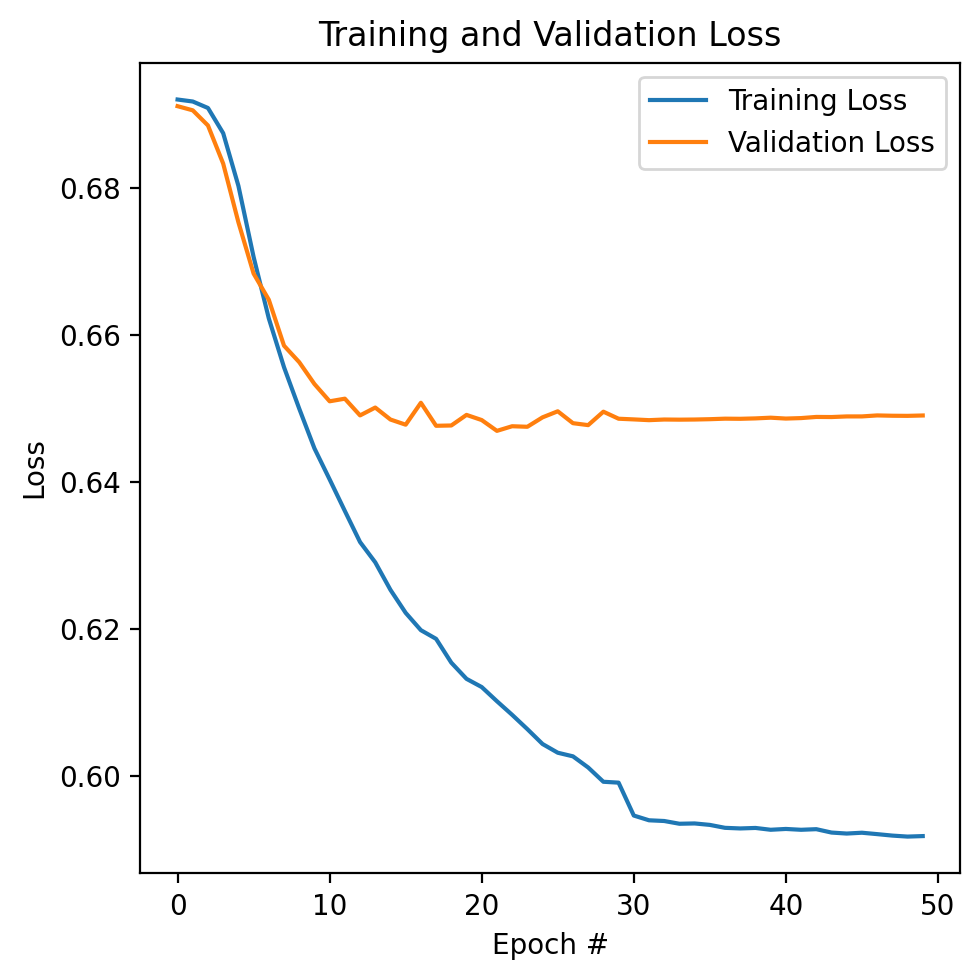

In [345]:
plot_learning(train_loss, valid_loss, "incorrect_stop_neural.jpg")

In [80]:
evaluate_model(model, test_dl)

╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.643872 │            0.638019 │    0.58956 │  0.638019 │        0.64 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


In [79]:
X_baseline = test_i_stop_res[test_i_stop_res["eventname"] == BASELINE][i_stop_go_features_res]
X_followup = test_i_stop_res[test_i_stop_res["eventname"] == FOLLOWUP][i_stop_go_features_res].reset_index(drop=True)
X_followup.drop(X_followup.tail(1).index,inplace=True)

X_diff = X_followup.reset_index(drop=True) - X_baseline.reset_index(drop=True)

X = pd.concat([X_baseline.reset_index(drop=True), X_followup.reset_index(drop=True), X_diff], keys=i_stop_go_features_res, axis=1)
X["demo_sex_v2"] = test_i_stop_res[test_i_stop_res["eventname"] == BASELINE].reset_index(drop=True)["demo_sex_v2"]
X = X.dropna()

y = X["demo_sex_v2"]
X = X.drop("demo_sex_v2", axis=1)

ds = ABCDDataset(X, y)
dl = DataLoader(ds, batch_size=32, shuffle=True)

evaluate_model(model, dl)

╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.532051 │            0.526279 │   0.459259 │  0.526279 │    0.506122 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


---

## 🧠 Structural MRI Data

---

### Not accounting for volume as a confounder

In [347]:
mri_features = [f[:-6] for f in mri_features_res]

X = mri[mri["eventname"] == BASELINE][mri_features]
X = z_normalize(X)
y = c_stop_res.iloc[X.index][TARGET]

X_train, X_test, y_train, y_test = get_split(X, y)
run_standard_models("Not accounting for volume: Structural MRI Baseline", X_train, X_test, y_train, y_test)

X_train shape: (4500, 71)
X_test shape: (1126, 71)
y_train shape: (4500,)
y_test shape: (1126,)


### Running `Not accounting for volume: Structural MRI Baseline` experiment

**=====================================================================**

**Trying SVC........**

Average cross-validation score: 66.244%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.650089 │            0.646599 │   0.612967 │  0.646599 │    0.635438 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying LogisticRegression........**

Average cross-validation score: 66.689%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.662522 │            0.659654 │    0.63035 │  0.659654 │    0.646707 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying RandomForestClassifier........**

Average cross-validation score: 62.289%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.600355 │             0.59324 │   0.530271 │   0.59324 │    0.589327 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying KNeighborsClassifier........**

Average cross-validation score: 58.022%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│    0.57016 │            0.565544 │   0.517928 │  0.565544 │    0.545073 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying MLPClassifier........**

Average cross-validation score: 52.711%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.531972 │                 0.5 │          0 │       0.5 │           0 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


/Users/alice/miniforge3/envs/pydata-book/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Considering volume as confounder

In [117]:
X = mri_res[mri_res["eventname"] == BASELINE][mri_features_res]
X = z_normalize(X)
y = c_stop_res.iloc[X.index][TARGET]

X_train, X_test, y_train, y_test = get_split(X, y)
trained_models = run_standard_models("Accounting for volume: Structural MRI Baseline", X_train, X_test, y_train, y_test)

X_train shape: (4500, 71)
X_test shape: (1126, 71)
y_train shape: (4500,)
y_test shape: (1126,)


### Running `Accounting for volume: Structural MRI Baseline` experiment

**=====================================================================**

**Trying SVC........**

Average cross-validation score: 62.311%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.625222 │            0.620718 │   0.578842 │  0.620718 │    0.610526 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying LogisticRegression........**

Average cross-validation score: 62.067%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.618117 │            0.613812 │   0.572565 │  0.613812 │    0.601253 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying RandomForestClassifier........**

Average cross-validation score: 58.667%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.590586 │            0.580409 │   0.490608 │  0.580409 │    0.587302 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying KNeighborsClassifier........**

Average cross-validation score: 56.333%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.565719 │            0.560116 │   0.504559 │  0.560116 │    0.541304 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying MLPClassifier........**

Average cross-validation score: 52.711%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.531972 │                 0.5 │          0 │       0.5 │           0 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


/Users/alice/miniforge3/envs/pydata-book/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [124]:
X = test_mri_res[test_mri_res["eventname"] == BASELINE]
y = test_c_stop_res.iloc[X.index][TARGET]
eval_standard_models(X, mri_features_res, trained_models, y_in=y)

SVC
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.474441 │                 0.5 │   0.643554 │       0.5 │    0.474441 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛
Logistic Regression
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.474441 │                 0.5 │   0.643554 │       0.5 │    0.474441 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛
RandomForestClassifier
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪═════

/Users/alice/miniforge3/envs/pydata-book/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


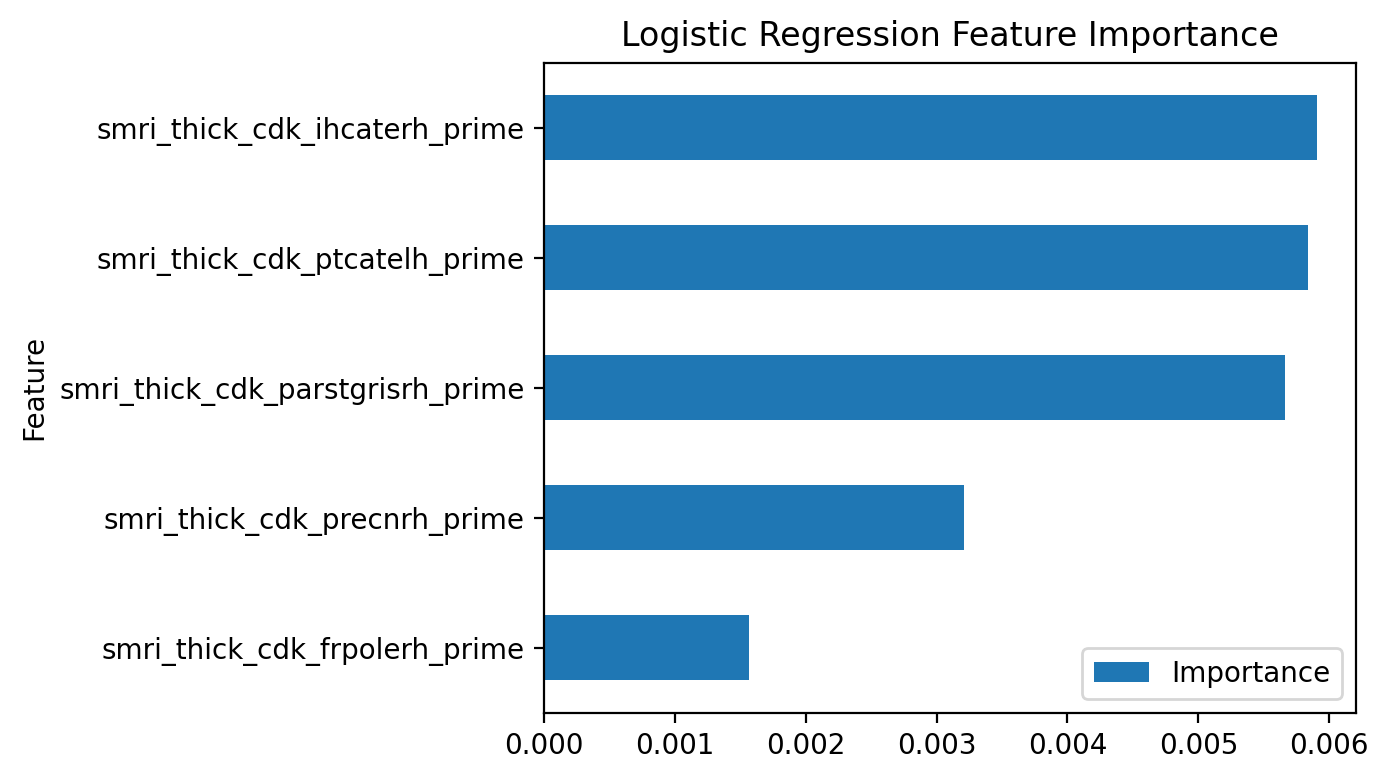

In [125]:
plot_feature_importance(mri_features_res, "baseline_mri_feature.jpg", n=1)

In [96]:
X = mri_res[mri_res["eventname"] == FOLLOWUP][mri_features_res]
X = z_normalize(X)
y = c_stop_res.iloc[X.index][TARGET]

X_train, X_test, y_train, y_test = get_split(X, y)
trained_figures = run_standard_models("Structural MRI Followup", X_train, X_test, y_train, y_test)

X_train shape: (4501, 71)
X_test shape: (1126, 71)
y_train shape: (4501,)
y_test shape: (1126,)


### Running `Structural MRI Followup` experiment

**=====================================================================**

**Trying SVC........**

Average cross-validation score: 61.320%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.631439 │            0.630288 │   0.590326 │  0.630288 │    0.654267 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying LogisticRegression........**

Average cross-validation score: 62.475%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.629663 │            0.628865 │   0.600957 │  0.628865 │    0.642127 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying RandomForestClassifier........**

Average cross-validation score: 58.720%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.575488 │            0.573413 │   0.486022 │  0.573413 │    0.604278 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying KNeighborsClassifier........**

Average cross-validation score: 55.454%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.547069 │            0.545873 │    0.49505 │  0.545873 │    0.550661 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying MLPClassifier........**

Average cross-validation score: 53.344%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.506217 │                 0.5 │          0 │       0.5 │           0 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


/Users/alice/miniforge3/envs/pydata-book/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


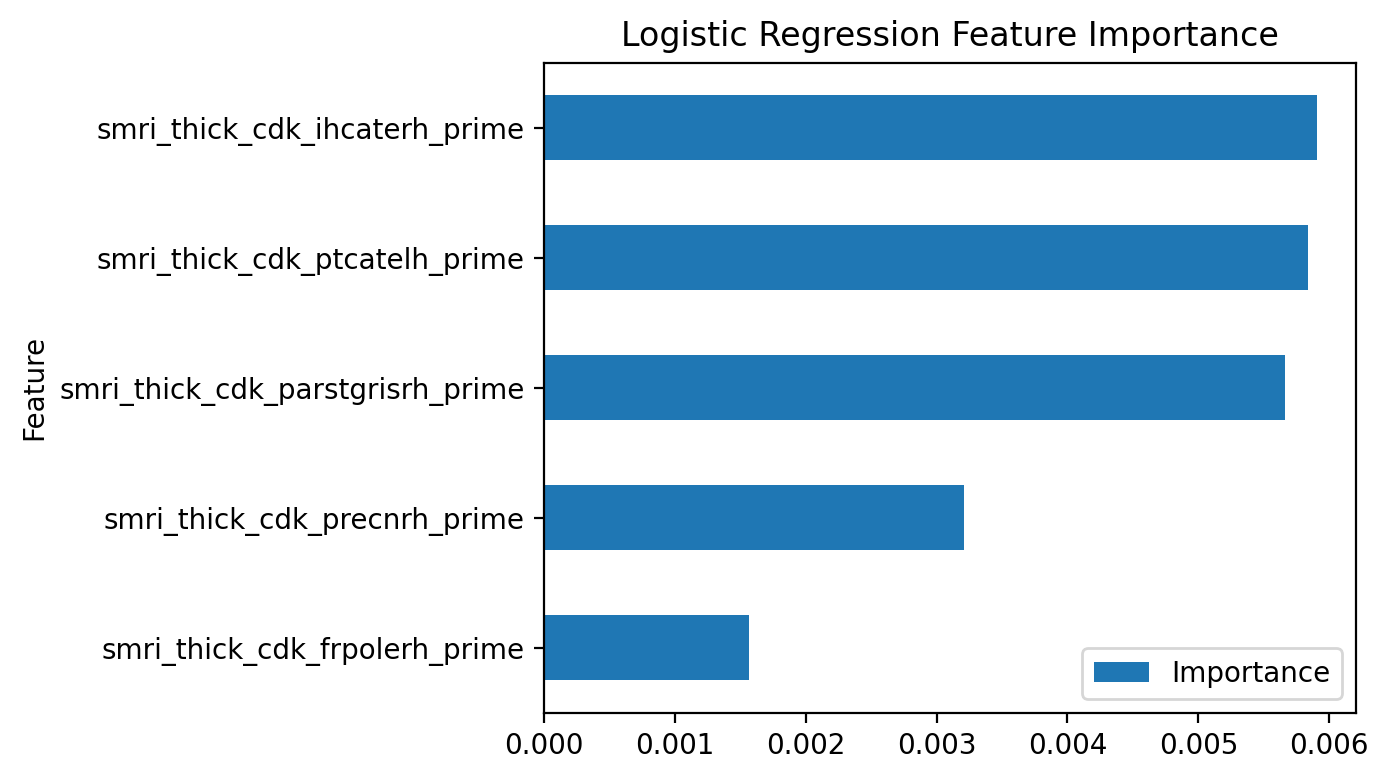

In [97]:
plot_feature_importance(mri_features_res, "followup_mri_feature.jpg", n=1)

In [63]:
X_baseline = mri_res[mri_res["eventname"] == BASELINE][mri_features_res]
X_followup = mri_res[mri_res["eventname"] == FOLLOWUP][mri_features_res]
X_followup.drop(X_followup.tail(1).index,inplace=True)

X_diff = X_followup.reset_index(drop=True) - X_baseline.reset_index(drop=True)
y = c_stop_res.iloc[X_baseline.index][TARGET]

X = z_normalize(X_diff)

X_train, X_test, y_train, y_test = get_split(X, y)
run_standard_models("Structural MRI, Followup - Baseline", X_train, X_test, y_train, y_test)

X_train shape: (4500, 71)
X_test shape: (1126, 71)
y_train shape: (4500,)
y_test shape: (1126,)


### Running `Structural MRI, Followup - Baseline` experiment

**=====================================================================**

**Trying SVC........**

Average cross-validation score: 58.889%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.611012 │            0.605424 │   0.554878 │  0.605424 │    0.597374 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying LogisticRegression........**

Average cross-validation score: 59.044%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.581705 │            0.576966 │   0.529471 │  0.576966 │    0.559072 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying RandomForestClassifier........**

Average cross-validation score: 56.867%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.594139 │            0.587283 │   0.525441 │  0.587283 │    0.580275 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying KNeighborsClassifier........**

Average cross-validation score: 54.644%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.533748 │            0.525162 │   0.439701 │  0.525162 │    0.502439 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying MLPClassifier........**

Average cross-validation score: 54.444%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.539964 │            0.512758 │    0.15082 │  0.512758 │    0.554217 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


In [64]:
X_baseline = mri_res[mri_res["eventname"] == BASELINE][mri_features_res]
X_followup = mri_res[mri_res["eventname"] == FOLLOWUP][mri_features_res]
X_followup.drop(X_followup.tail(1).index,inplace=True)

X_diff = X_followup.reset_index(drop=True) - X_baseline.reset_index(drop=True)
y = c_stop_res.iloc[X_baseline.index][TARGET]

X = pd.concat([X_baseline.reset_index(drop=True), X_diff], keys=mri_features_res, axis=1)
X = z_normalize(X)

X_train, X_test, y_train, y_test = get_split(X, y)
run_standard_models("Structural MRI, Baseline + (Followup - Baseline)", X_train, X_test, y_train, y_test)

X_train shape: (4500, 142)
X_test shape: (1126, 142)
y_train shape: (4500,)
y_test shape: (1126,)


### Running `Structural MRI, Baseline + (Followup - Baseline)` experiment

**=====================================================================**

**Trying SVC........**

Average cross-validation score: 64.800%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.646536 │            0.643603 │    0.61284 │  0.643603 │    0.628743 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying LogisticRegression........**

Average cross-validation score: 64.533%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.637655 │            0.634685 │   0.603113 │  0.634685 │    0.618762 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying RandomForestClassifier........**

Average cross-validation score: 59.556%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.596803 │              0.5907 │   0.534836 │    0.5907 │    0.581292 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying KNeighborsClassifier........**

Average cross-validation score: 56.067%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.569272 │            0.561288 │   0.486772 │  0.561288 │    0.550239 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying MLPClassifier........**

Average cross-validation score: 55.444%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│    0.57016 │            0.582422 │   0.627692 │  0.582422 │    0.527814 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


In [45]:
X_baseline = mri_res[mri_res["eventname"] == BASELINE][mri_features_res]
X_followup = mri_res[mri_res["eventname"] == FOLLOWUP][mri_features_res]
X_followup.drop(X_followup.tail(1).index,inplace=True)

X_diff = X_followup.reset_index(drop=True) - X_baseline.reset_index(drop=True)
y = c_stop_res.iloc[X_baseline.index][TARGET]

X = pd.concat([X_baseline.reset_index(drop=True), X_followup.reset_index(drop=True), X_diff], keys=mri_features_res, axis=1)
X = z_normalize(X)

X_train, X_test, y_train, y_test = get_split(X, y)
trained_models = run_standard_models("Structural MRI, Baseline + Followup + (Followup - Baseline)", X_train, X_test, y_train, y_test)

X_train shape: (4500, 213)
X_test shape: (1126, 213)
y_train shape: (4500,)
y_test shape: (1126,)


### Running `Structural MRI, Baseline + Followup + (Followup - Baseline)` experiment

**=====================================================================**

**Trying SVC........**

Average cross-validation score: 64.889%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.652753 │            0.649446 │   0.617042 │  0.649446 │    0.637652 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying LogisticRegression........**

Average cross-validation score: 64.556%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│    0.64032 │            0.637418 │   0.606414 │  0.637418 │    0.621514 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying RandomForestClassifier........**

Average cross-validation score: 59.578%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.599467 │            0.592292 │   0.528736 │  0.592292 │    0.588372 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying KNeighborsClassifier........**

Average cross-validation score: 57.222%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.546181 │            0.537647 │   0.454642 │  0.537647 │    0.519512 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


**Trying MLPClassifier........**

Average cross-validation score: 62.956%
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.638544 │            0.635064 │   0.600589 │  0.635064 │    0.621951 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


In [60]:
X_baseline = test_mri_res[test_mri_res["eventname"] == BASELINE][mri_features_res]
X_followup = test_mri_res[test_mri_res["eventname"] == FOLLOWUP][mri_features_res]
X_followup.drop(X_followup.tail(1).index,inplace=True)

X_diff = X_followup.reset_index(drop=True) - X_baseline.reset_index(drop=True)
y = test_c_stop_res[test_c_stop_res["eventname"] == BASELINE][TARGET]

X = pd.concat([X_baseline.reset_index(drop=True), X_followup.reset_index(drop=True), X_diff], keys=mri_features_res, axis=1)
X = z_normalize(X)

print(X.shape)
print(y.shape)

(626, 213)
(626,)


In [63]:
eval_standard_models_Xy(X[:-2], y[:-2], trained_models)

SVC
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│    0.55609 │            0.552228 │   0.506239 │  0.552228 │    0.533835 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛
Logistic Regression
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.543269 │            0.540596 │   0.504348 │  0.540596 │    0.517857 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛
RandomForestClassifier
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪═════

### PyTorch Model using Baseline, Followup and Followup - Baseline

In [64]:
X_baseline = mri_res[mri_res["eventname"] == BASELINE][mri_features_res]
X_followup = mri_res[mri_res["eventname"] == FOLLOWUP][mri_features_res]
X_followup.drop(X_followup.tail(1).index,inplace=True)

X_diff = X_followup.reset_index(drop=True) - X_baseline.reset_index(drop=True)
y = c_stop_res.iloc[X_baseline.index][TARGET]

X = pd.concat([X_baseline.reset_index(drop=True), X_followup.reset_index(drop=True), X_diff], keys=mri_features_res, axis=1)
X = z_normalize(X)

In [65]:
torch.manual_seed(42)

model = Model1(len(X.columns))
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

train_dl, test_dl = get_dls(X, y)
print(model)

X_train shape: (4500, 213)
X_test shape: (1126, 213)
y_train shape: (4500,)
y_test shape: (1126,)
Model1(
  (layers): Sequential(
    (0): Linear(in_features=213, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=2, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2, out_features=2, bias=True)
    (5): Sigmoid()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (softmax): Softmax(dim=1)
)


In [66]:
train_loss, valid_loss = train_model(model, loss_function, optimizer, train_dl, test_dl, NUM_EPOCHS)

Epoch 1/50 - Train loss: 0.69 Valid loss: 0.68
Epoch 11/50 - Train loss: 0.60 Valid loss: 0.64
Epoch 21/50 - Train loss: 0.59 Valid loss: 0.64
Epoch 31/50 - Train loss: 0.58 Valid loss: 0.64
Epoch 41/50 - Train loss: 0.58 Valid loss: 0.64
Training Completed!


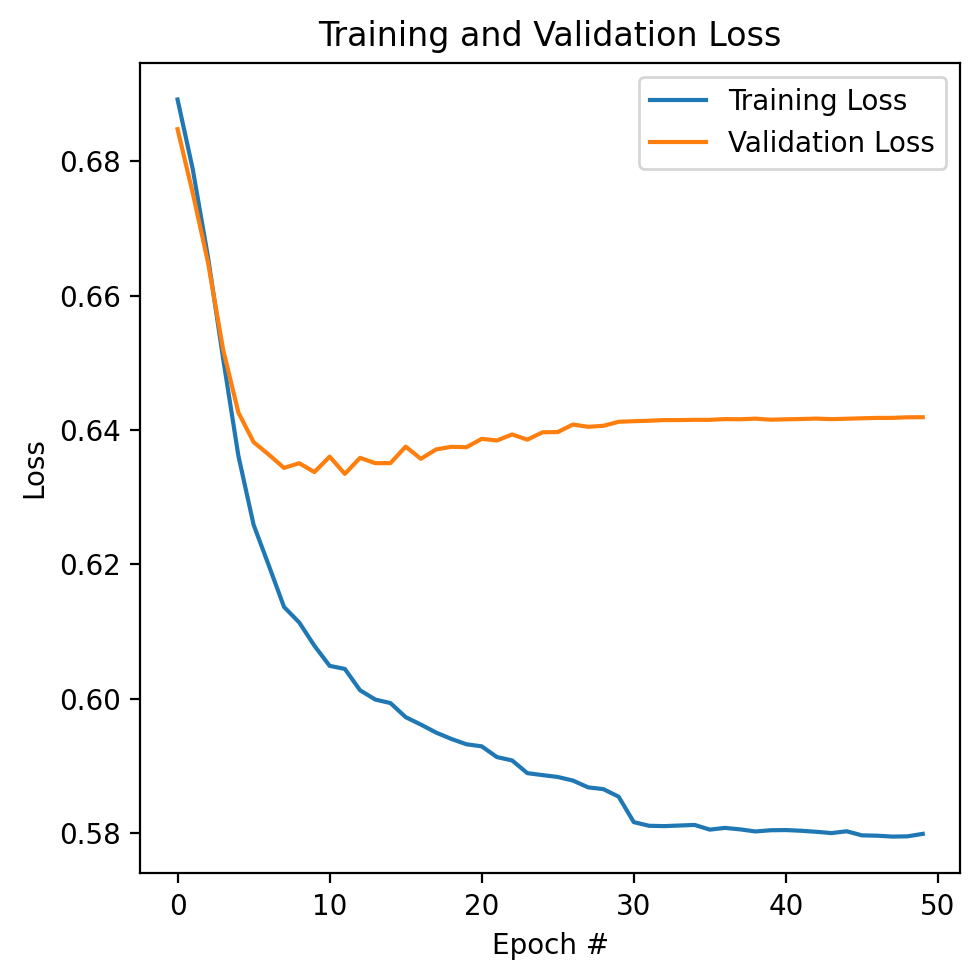

In [431]:
plot_learning(train_loss, valid_loss, "structuralneural.jpg")

In [432]:
evaluate_model(model, test_dl)

╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.646536 │            0.641322 │   0.597166 │  0.641322 │    0.639913 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


In [71]:
X_baseline = test_mri_res[test_mri_res["eventname"] == BASELINE][mri_features_res]
X_followup = test_mri_res[test_mri_res["eventname"] == FOLLOWUP][mri_features_res]
X_followup.drop(X_followup.tail(1).index,inplace=True)

X_diff = X_followup.reset_index(drop=True) - X_baseline.reset_index(drop=True)
y = test_c_stop_res[test_c_stop_res["eventname"] == BASELINE][TARGET]

X = pd.concat([X_baseline.reset_index(drop=True), X_followup.reset_index(drop=True), X_diff], keys=mri_features_res, axis=1)
X = z_normalize(X)

print(X.shape)
print(y.shape)

(626, 213)
(626,)


In [74]:
ds = ABCDDataset(X, y)
dl = DataLoader(ds, batch_size=32, shuffle=True)

evaluate_model(model, dl)

╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.573482 │            0.569008 │   0.517179 │  0.569008 │    0.558594 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


---

## Predict before or after pandemic

---

In [442]:
def get_combined(df, features):
    baseline = df[df["eventname"] == BASELINE]
    followup = df[df["eventname"] == FOLLOWUP]
    followup = followup.drop(followup.tail(1).index)

    baseline = baseline[["src_subject_id", "interview_age"] + features]
    followup = followup[["src_subject_id", "interview_age"] + features]
    
    baseline["demo_sex_v2"] = c_stop_res[c_stop_res["eventname"] == BASELINE]["demo_sex_v2"]
    combined = baseline.merge(followup, on="src_subject_id")

    combined["age_diff"] = combined["interview_age_y"] - combined["interview_age_x"]
    combined["delayed"] = combined["age_diff"] > 28
    combined["delayed"] = combined["delayed"].replace({False: 0, True: 1})
    
    return combined

In [443]:
combined = get_combined(c_stop_res, c_stop_go_features_res)
combined["delayed"].value_counts()

delayed
0    5057
1     569
Name: count, dtype: int64

In [448]:
zeros = combined["delayed"].value_counts().iloc[0]
ones = combined["delayed"].value_counts().iloc[1]

targets = np.concatenate((np.zeros(zeros), np.ones(ones)), axis=0)
class_weights = compute_class_weight('balanced', classes=[0, 1], y=targets)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

In [472]:
all_features = [c + "_x" for c in mri_features_res] + [c + "_y" for c in mri_features_res]
combined = get_combined(mri_res, mri_features_res)
X = combined[all_features]
y = combined["delayed"]
y_one_hot = pd.DataFrame(np.eye(2)[y])

X = z_normalize(X)

torch.manual_seed(42)

model = Model1(len(X.columns))

loss_function = BCEWithLogitsLoss(pos_weight=class_weights[1])
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

train_dl, test_dl = get_dls(X, y_one_hot)
print(model)

X_train shape: (4500, 142)
X_test shape: (1126, 142)
y_train shape: (4500, 2)
y_test shape: (1126, 2)
Model1(
  (layers): Sequential(
    (0): Linear(in_features=142, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=2, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2, out_features=2, bias=True)
    (5): Sigmoid()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (softmax): Softmax(dim=1)
)


In [473]:
train_loss, valid_loss = train_model(model, loss_function, optimizer, train_dl, test_dl, NUM_EPOCHS, bce=True)

Epoch 1/50 - Train loss: 1.74 Valid loss: 1.72
Epoch 11/50 - Train loss: 1.45 Valid loss: 1.44
Epoch 21/50 - Train loss: 1.34 Valid loss: 1.33
Epoch 31/50 - Train loss: 1.29 Valid loss: 1.29
Epoch 41/50 - Train loss: 1.29 Valid loss: 1.29
Training Completed!


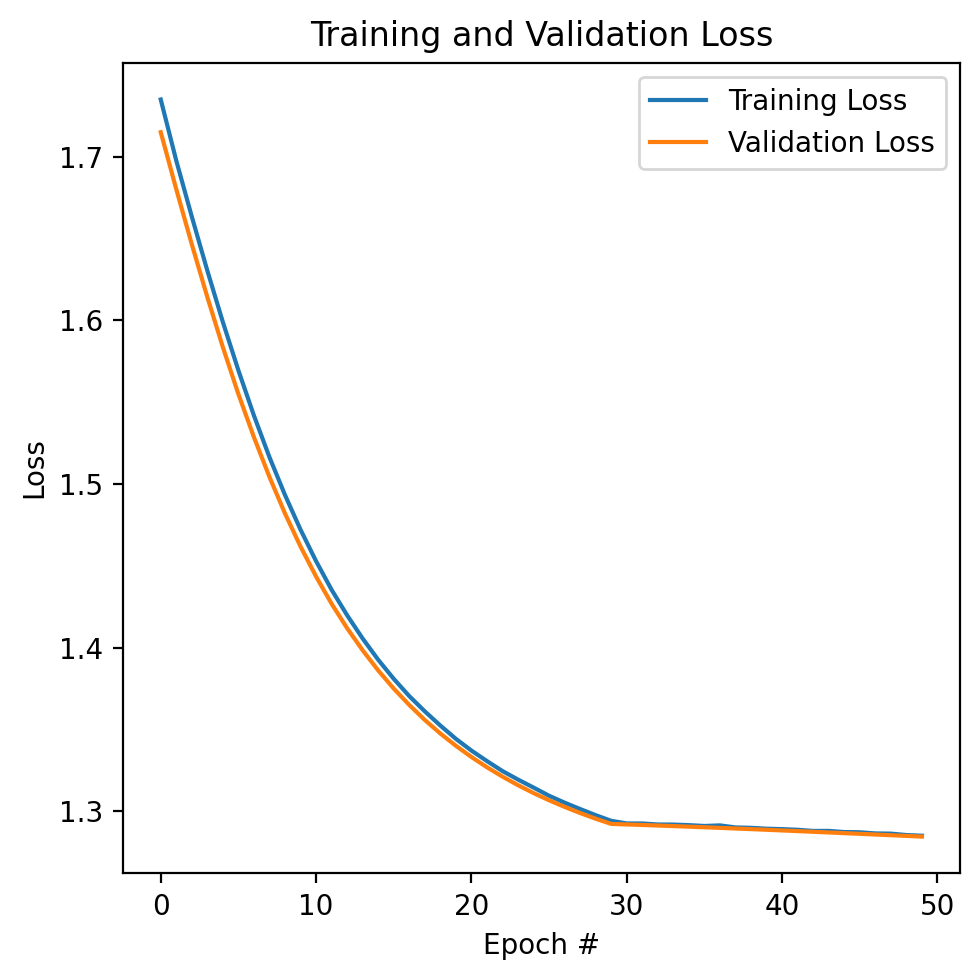

In [470]:
plot_learning(train_loss, valid_loss, "beforeafterpandemic.jpg")

In [474]:
_, test_dl = get_dls(X, y)
evaluate_model(model, test_dl)

X_train shape: (4500, 142)
X_test shape: (1126, 142)
y_train shape: (4500,)
y_test shape: (1126,)
╒════════════╤═════════════════════╤════════════╤═══════════╤═════════════╕
│   Accuracy │   Balanced Accuracy │   f1 Score │   ROC AUC │   Precision │
╞════════════╪═════════════════════╪════════════╪═══════════╪═════════════╡
│   0.900533 │                 0.5 │          0 │       0.5 │           0 │
╘════════════╧═════════════════════╧════════════╧═══════════╧═════════════╛


/Users/alice/miniforge3/envs/pydata-book/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
